# Lab1 - Back Propagation

建造一個具有兩層hidden layers的model，並計算forward和backward propagation，來預測Linear和XOR dataset。

In [3]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True) # don't use scientific notation

### Dataset generation

x: shape = (number of data, input dimension)<br>
y: shape = (number of data, label)

- linear:
  - label = 0, x1 > x2 which falls on the bottom-right side.
  - label = 1, x1 < x2 which falls on the upper-left side.

- XOR:
  - label = 0, x2 = x1
  - label = 1, x2 = 1 - x1

In [4]:
def generate_linear(n=100, seed=10):
  np.random.seed(seed)
  pts = np.random.uniform(0, 1, (n, 2))
  inputs = []
  labels = []
  for pt in pts:
    inputs.append([pt[0], pt[1]])
    distance = (pt[0]-pt[1])/1.414
    if pt[0] > pt[1]:
      labels.append(0)
    else:
      labels.append(1)

  return np.array(inputs), np.array(labels).reshape(n, 1)

In [5]:
def generate_XOR_easy(n=10):
  inputs = []
  labels = []
  for i in range(n+1):
    inputs.append([0.1*i, 0.1*i])
    labels.append(0)
  
    if 0.1*i == 0.5:
      continue
    
    inputs.append([0.1*i, 1-0.1*i])
    labels.append(1)

  return np.array(inputs), np.array(labels).reshape(2*n+1, 1)

## Activation Function

### Sigmoid
$$ \sigma = \frac{1}{1+e^{-x}} $$

$$ \frac{\partial\sigma}{\partial x} = \sigma(x)(1-\sigma(x))   $$

In [6]:
def sigmoid(x):
  return 1.0/(1.0 + np.exp(-x))

def derivative_sigmoid(x):
  return np.multiply(sigmoid(x), 1-sigmoid(x))

In [7]:
def tanh(x):
    return np.tanh(x)
    
def derivative_tanh(x):
    return np.power(1./np.cosh(x), 2)

## Neural Network Model

In [8]:
def init_parameter(nx, nh1, nh2, ny):
  w1 = np.random.randn(nx, nh1)
  # b1 = np.zeros([100, 1]) 
  w2 = np.random.randn(nh1, nh2)
  # b2 = np.zeros([100, 1]) 
  w3 = np.random.randn(nh2, ny)
  # b3 = np.zeros([100, 1])

  return w1, w2, w3

# init_parameter(2, 10, 10, 1)

In [9]:
def forward(x, parameters):
  w1, w2, w3 = parameters

  z1 = np.dot(x, w1)
  a1 = tanh(z1)
  z2 = np.dot(a1, w2)
  a2 = tanh(z2)
  z3 = np.dot(a2, w3)
  a3 = sigmoid(z3)

  return z1, a1, z2, a2, z3, a3

In [10]:
def loss_func(y, y_pred):
  m = y.shape[0]
  cost_sum = np.multiply(np.log(y_pred), y) + np.multiply((1 - y), np.log(1 - y_pred))
  cost = - np.sum(cost_sum) / m
  cost = np.squeeze(cost)
  return cost

In [11]:
def backward(parameters, neural, x, y):
  m = y.shape[0]
  w1, w2, w3 = parameters
  z1, a1, z2, a2, z3, a3 = neural

  # output to hidden layer 2
  da3 = - np.divide(y, a3) + np.divide(1-y, 1-a3)
  dz3 = da3 * derivative_sigmoid(z3)
  dw3 = 1/m * np.dot(a2.T, dz3)

  # hidden layer 2 to hidden layer 1
  da2 = np.dot(dz3, w3.T)
  dz2 = da2 * derivative_tanh(z2)
  dw2 = 1/m * np.dot(a1.T, dz2)
  
  # hidden layer 1 to input
  da1 = np.dot(dz2, w2.T)
  dz1 = da1 * derivative_tanh(z1)
  dw1 = 1/m * np.dot(x.T, dz1)

  return dw1, dw2, dw3

In [12]:
def update_parameters(parameters, gradients, lr=0.01):
  dw1, dw2, dw3 = gradients
  w1, w2, w3 = parameters

  w1 = w1 - lr*dw1
  w2 = w2 - lr*dw2
  w3 = w3 - lr*dw3

  return w1, w2, w3

In [13]:
def accuracy(x, y, y_pred):
  correct = 0
  for i in range(y.shape[0]):
    if y_pred[i,:] < 0.5 and y[i]==0:
      correct += 1
    elif y_pred[i,:] > 0.5 and y[i]==1:
      correct += 1
  return correct / y_pred.shape[0]

In [14]:
def model(x, y, nh1, nh2, iter=10000, lr=0.01, linear=False, xor=False):
    costs = []
    accs = []
    test_costs = []
    test_accs = []
    nx = x.shape[1]
    ny = y.shape[1]

    # init parameters
    parameters = init_parameter(nx, nh1, nh2, ny)
    for i in range(iter):
        neural = forward(x, parameters)
        cost = loss_func(y, neural[5])
        gradients = backward(parameters, neural, x, y)
        parameters = update_parameters(parameters, gradients, lr)

        if i % 500 == 0:
            *_, y_pred = forward(x, parameters)
            acc = accuracy(x, y, y_pred)

            # testing
            seed = np.random.randint(low=0, high=10000, size=1)
            if linear:
                x_test, y_test = generate_linear(100, seed)
            elif xor:
                x_test, y_test = generate_XOR_easy(20)
            *_, y_pred = forward(x_test, parameters)
            test_cost = loss_func(y_test, y_pred)
            test_acc = accuracy(x_test, y_test, y_pred)
            costs.append(cost)
            test_costs.append(test_cost)
            accs.append(acc)
            test_accs.append(test_acc)
            print("epoch {} training loss : {} acc : {}, testing loss : {} acc : {}".format(i, cost, acc, test_cost, test_acc))

    return parameters, costs, accs, test_costs, test_accs

In [15]:
def show_result(x, y, pred_y):
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.title('Ground truth', fontsize=18)
  plt.xlabel("x1", fontsize=12)
  plt.ylabel("x2", fontsize=12)
  for i in range(x.shape[0]):
    if y[i] == 0:
      plt.plot(x[i][0], x[i][1], 'ro')
    else:
      plt.plot(x[i][0], x[i][1], 'bo')

  plt.subplot(1, 2, 2)
  plt.title('Predict result', fontsize=18)
  plt.xlabel("x1", fontsize=12)
  plt.ylabel("x2", fontsize=12)
  for i in range(x.shape[0]):
    if pred_y[i,:] < 0.5:
      plt.plot(x[i][0], x[i][1], 'ro')
    else:
      plt.plot(x[i][0], x[i][1], 'bo')
  plt.tight_layout()
  plt.show()
  
def plot_loss(iter, step, costs, test_costs):
  plt.title('Learning Curve', fontsize=18)  
  plt.xlabel("Epoch", fontsize=12)
  plt.ylabel("Loss", fontsize=12)
  x = np.arange(0, iter, step)
  plt.plot(x, costs, label = "training")
  plt.plot(x, test_costs, label = "testing")
  plt.legend()
  plt.tight_layout()
  plt.show()


def plot_acc(iter, step, accs, test_accs):
  plt.figure(figsize=(5, 5))
  plt.title("Accuracy", fontsize=18)
  plt.xlabel("Epoch", fontsize=12)
  plt.ylabel("Accuracy", fontsize=12)
  x = np.arange(0, iter, step)
  plt.plot(x, accs, label = "training")
  plt.plot(x, test_accs, label = "testing")
  plt.legend()
  plt.tight_layout()
  plt.show()

epoch 0 training loss : 1.2796583109616086 acc : 0.42, testing loss : 1.1371019913855915 acc : 0.5
epoch 500 training loss : 0.27328821859394387 acc : 0.98, testing loss : 0.27610519181377957 acc : 0.98
epoch 1000 training loss : 0.14486823017093955 acc : 0.99, testing loss : 0.21139793599983825 acc : 0.97
epoch 1500 training loss : 0.10219183112988008 acc : 0.99, testing loss : 0.11781211894214474 acc : 0.99
epoch 2000 training loss : 0.08092963318472933 acc : 1.0, testing loss : 0.082844793841809 acc : 1.0
epoch 2500 training loss : 0.06788370494138053 acc : 1.0, testing loss : 0.0817639247104133 acc : 1.0
epoch 3000 training loss : 0.05891065400909044 acc : 1.0, testing loss : 0.04636651656334816 acc : 1.0
epoch 3500 training loss : 0.05228570068476483 acc : 1.0, testing loss : 0.06675328904337793 acc : 0.99
epoch 4000 training loss : 0.047155563255148115 acc : 1.0, testing loss : 0.04707301461026361 acc : 1.0
epoch 4500 training loss : 0.04304603453669067 acc : 1.0, testing loss : 

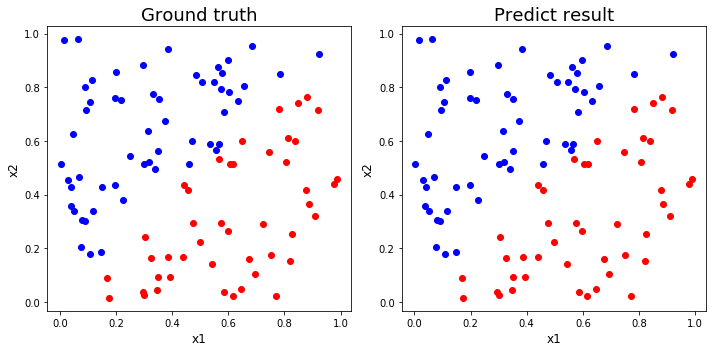

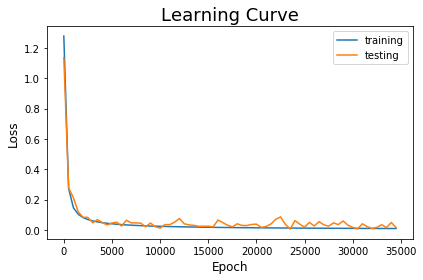

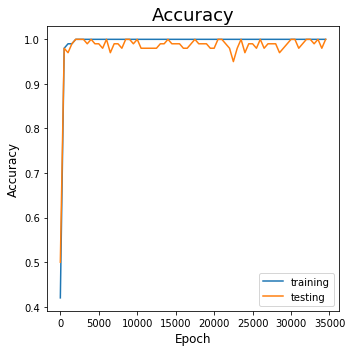

In [16]:
# Linear training
iter = 35000
seed = 10
x_train_linear, y_train_linear = generate_linear(100, seed)
parameters_linear, costs_linear, accs_linear, test_costs_linear, test_accs_linear = model(x_train_linear, y_train_linear, 10, 10, iter=iter, lr=0.01, linear=True)
*_, y_pred_linear = forward(x_train_linear, parameters_linear)
# print(y_pred_linear)
show_result(x_train_linear, y_train_linear, y_pred_linear)
plot_loss(iter, 500, costs_linear, test_costs_linear)
plot_acc(iter, 500, accs_linear, test_accs_linear)

In [ ]:
# XOR training
iter = 150000
seed = 10
x_train_xor, y_train_xor = generate_XOR_easy(10)
parameters_xor, costs_xor, accs_xor, test_costs_xor, test_accs_xor = model(x_train_xor, y_train_xor, 10, 10, iter=iter, lr=0.01, xor=True)
*_, y_pred_xor = forward(x_train_xor, parameters_xor)
# print(y_pred_linear)
show_result(x_train_xor, y_train_xor, y_pred_xor)
plot_loss(iter, 5000, costs_xor, test_costs_xor)
plot_acc(iter, 5000, accs_xor, test_accs_xor)

In [ ]:
# linear test
seed = np.random.randint(low=0, high=10000, size=1)
x_test, y_test = generate_linear(1000, seed)
*_, y_pred = forward(x_test, parameters_linear)
print("acc:", accuracy(x_test, y_test, y_pred))
show_result(x_test, y_test, y_pred)

In [ ]:
# xor test
x_test, y_test = generate_XOR_easy(100)
*_, y_pred = forward(x_test, parameters_xor)
print("acc:", accuracy(x_test, y_test, y_pred))
show_result(x_test, y_test, y_pred)

In [17]:
costs_linear

[1.2796583109616086,
 0.27328821859394387,
 0.14486823017093955,
 0.10219183112988008,
 0.08092963318472933,
 0.06788370494138053,
 0.05891065400909044,
 0.05228570068476483,
 0.047155563255148115,
 0.04304603453669067,
 0.03967009865517608,
 0.036842110167906034,
 0.0344354539190782,
 0.032360086192703995,
 0.03054989711651551,
 0.028955186155565166,
 0.027537914874104678,
 0.026268545542501735,
 0.02512384479899687,
 0.024085314582864132,
 0.02313805243880334,
 0.022269915132252675,
 0.02147089991610811,
 0.020732683129560357,
 0.020048273048249937,
 0.019411746105537718,
 0.01881804433702629,
 0.018262818142761247,
 0.017742302905748453,
 0.01725322116119379,
 0.0167927042522047,
 0.016358229004508024,
 0.015947566096718217,
 0.015558737628371077,
 0.015189981989111145,
 0.014839724574319271,
 0.014506553220526045,
 0.01418919747994442,
 0.013886511039721106,
 0.01359745673389676,
 0.013321093705904794,
 0.013056566364901436,
 0.01280309484625363,
 0.012559966739491588,
 0.012326529